In [1]:
# run this only if you have not installed the requried packages
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install rasterio
# !pip install geopandas
# !pip install fiona

### Loading required libraries

In [2]:
import os
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import pickle
from sklearn.metrics import classification_report, accuracy_score

### Providing the path to the data

In [3]:
# variables 
# Note: labels should be always last column with name "labels"
# Note: Make sure input labels shapefile and input raster have same CRS, otherwise code will not run

# input files
raster_loc = 'materials/rasters/s2image.tif'
points_loc = 'materials/shapefiles/samples.shp'
temp_point_loc = 'materials/temp/temp_y_points.shp'
temp_point_csv = 'export.csv'

# land cover names (for post visualization)
lulc_name = ['Water', 'Barren Land', 'Veg', 'Built-up']

In [4]:
# make path file
file_names = os.listdir('materials/rasters')
file_names_list = [i[:-4] for i in file_names if i.endswith('.tif')]
raster_loc_list = ['materials/rasters/' + i + '.tif' for i in file_names_list]
points_loc_list = ['materials/shapefiles/' + i + '.shp' for i in file_names_list]
temp_point_csv_list = ['materials/CSV/' + i + '.csv' for i in file_names_list]

In [5]:
# check path
# print(raster_loc_list,'\n',points_loc_list,'\n',temp_point_csv_list)

In [6]:
def img_to_csv(raster_loc, points_loc, temp_point_csv):
    
    
    with rio.open(raster_loc) as img:
        bands = (img.read()).shape[0]
    print('Bands of input image: ', bands)

    # using ilteration to automatically create a bands list

    features = []
    for i in range(bands):
        features.append('band'+str(i+1))
    print('Bands names: ', features)
    f_len = len(features)

    points = gpd.read_file(points_loc)
    # adding a new column 'id' with range of points
    points = points.assign(id=range(len(points)))
    # saving nenw point file with 'id'
    points.to_file(temp_point_loc) 
    # converting gdf to pd df and removing geometry
    points_df = pd.DataFrame(points.drop(columns='geometry'))

    # ilterating over multiband raster
    sampled = pd.Series()

    #inputShape= temp_point_loc
    # Read input shapefile with fiona and iterate over each feature
    with fiona.open(temp_point_loc) as shp:
        # checking the shapfile meta data
        print(shp.meta) 
        print(shp.schema) 
        for feature in shp:
            siteID = feature['properties']['id']
            coords = feature['geometry']['coordinates']
            # Read pixel value at the given coordinates using Rasterio
            # NB: `sample()` returns an iterable of ndarrays.
            with rio.open(raster_loc) as stack_src:
                    value = [v for v in stack_src.sample([coords])]
            # Update the pandas serie accordingly
            sampled.loc[siteID] = value

    # reshaping sampled values
    df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
    # df1['id'] = df1.index
    df1 = pd.DataFrame(df1[0].values.tolist(), 
                    columns=features)

    df1['id'] = df1.index

    data = pd.merge(df1, points_df, on ='id')
    print('Sampled Data: \n',data)

    data.to_csv(temp_point_csv)

    x = data.iloc[:,0:f_len]
    X = x.values
    y = data.iloc[:,-1]
    Y = y.values

    return f_len
    

In [7]:
for i in range(len(raster_loc_list)):
    raster_loc = raster_loc_list[i]
    points_loc = points_loc_list[i]
    temp_point_csv = temp_point_csv_list[i]
    f_len = img_to_csv(raster_loc, points_loc, temp_point_csv)

Bands of input image:  4
Bands names:  ['band1', 'band2', 'band3', 'band4']
{'driver': 'ESRI Shapefile', 'schema': {'properties': {'labels': 'int:18', 'id': 'int:18'}, 'geometry': 'Point'}, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]'), 'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]'}
{'properties': {'labels': 'int:18', 'id': 'int:18'}, 'geometry': 'Point'}
Sampled Data: 
      band1   band2   band3   band4  id  labels
0   0.2310  0.2676  0.1773  0.1217   0       1
1   0.2266  0.2730  0.1889  0.1238   1       1
2   0.2266  0.2558  0.1703  0.1220   2       1
3   0.2222  0.2494  0.1616  0.1227   3

# read csv file from folder for build dataset

In [8]:
All_df = pd.DataFrame()
for file in temp_point_csv_list:
    df = pd.read_csv(file, index_col=[0])
    All_df = pd.concat([All_df, df], ignore_index=True)

All_df['id'] = All_df.index
All_df

,band1,band2,band3,band4,id,labels
0,0.2310,0.2676,0.1773,0.1217,0,1
1,0.2266,0.2730,0.1889,0.1238,1,1
2,0.2266,0.2558,0.1703,0.1220,2,1
3,0.2222,0.2494,0.1616,0.1227,3,1
4,0.2156,0.2304,0.1445,0.1218,4,1
...,...,...,...,...,...,...
144,0.6240,0.4760,0.6480,0.5504,144,4
145,0.1985,0.2226,0.3492,0.3884,145,4
146,0.1520,0.1744,0.1628,0.3834,146,3
147,0.1414,0.1657,0.1416,0.4868,147,3


# set X and Y values

In [9]:
x = All_df.iloc[:,0:-2]
X = x.values
y = All_df.iloc[:,-1]
Y = y.values

# Test and Train split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (104, 4)
X_test Shape: (45, 4)
y_train Shape: (104,)
y_test Shape:(45,)


# Support Vector Machine (SVM)

Accuracy SVM: 91.11111111111111
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       0.89      0.73      0.80        11
           3       1.00      1.00      1.00        13
           4       0.82      0.93      0.87        15

    accuracy                           0.91        45
   macro avg       0.93      0.92      0.92        45
weighted avg       0.91      0.91      0.91        45

Confusion Matrix RF: 
 [[ 6  0  0  0]
 [ 0  8  0  3]
 [ 0  0 13  0]
 [ 0  1  0 14]]


Text(48.65625, 0.5, 'Actual')

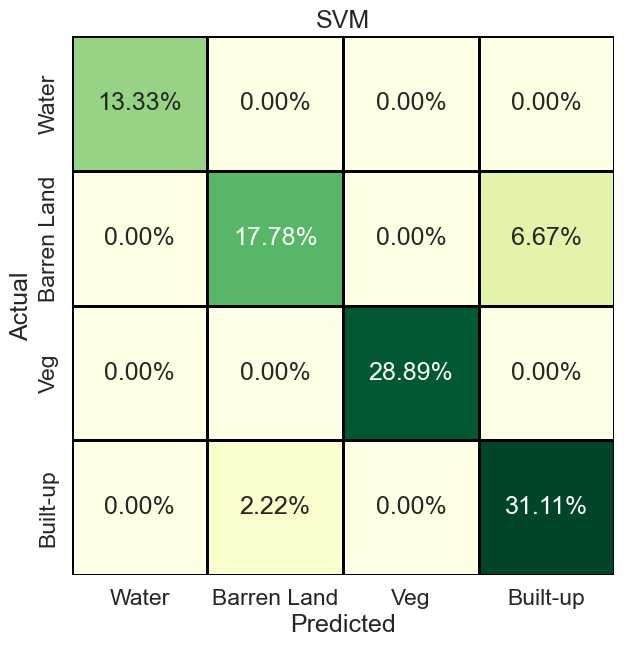

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
cName = 'SVM'
clf_svm = SVC(kernel='rbf')
clf_svm.fit(X_train, y_train)

clf_pred = clf_svm.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

# Save SVM Model

In [20]:
# save the model to disk
filename = 'Model/finalized_model_svm.sav'
pickle.dump(clf_svm, open(filename, 'wb'))
 
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print('SVM Model Score: ', result)

SVM Model Score:  0.9111111111111111


## full data reshaping, predicting, and saving output

In [13]:
def image_mapper_SVM(raster_loc, raster_file_name):
    
    cName = 'SVM'
    exp_name = f'materials/results/lulc_{cName}_{raster_file_name}.tif'


    img = rio.open(raster_loc)
    img_arr = img.read()
    bands = img_arr.shape[0]
    print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
    img_n = np.moveaxis(img_arr, 0, -1) # change shape: (4, 406, 763) ===> (406, 763, 4)
    img_n = img_n.reshape(-1, f_len) # change shape: (406, 763, 4) ===> (406*763, 4)
    print('reshaped full data shape  for prediction: ',img_n.shape)
    metadata = img.meta
    height = metadata.get('height')
    width = metadata.get('width')
    crs = metadata.get('crs')
    transform = metadata.get('transform')


    pred_full = loaded_model.predict(img_n)

    print('Prediction Done, now exporting raster \n')

    img_reshape = pred_full.reshape(height, width)

    out_raster = rio.open(exp_name,
                                            'w',
                                            driver='GTiff',
                                            height=height,
                                            width=width,
                                            count=1,
                                            dtype='uint8',
                                            crs=crs,
                                            transform = transform,
                                            nodata = 255 #nodata
                                            )

    out_raster.write(img_reshape, 1)
    out_raster.close()

    print(f'Raster Map of {raster_file_name} generated by {cName} algorithm was saved!')
    print(100*'#','\n\n')

In [14]:
for i, path_file in enumerate(raster_loc_list):
    image_mapper_SVM(path_file, file_names_list[i])

Height: 960
Width: 1621
Bands: 4

reshaped full data shape  for prediction:  (1556160, 4)
Prediction Done, now exporting raster 

Raster Map of area1 generated by SVM algorithm was saved!
#################################################################################################### 


Height: 209
Width: 451
Bands: 4

reshaped full data shape  for prediction:  (94259, 4)
Prediction Done, now exporting raster 

Raster Map of area2 generated by SVM algorithm was saved!
#################################################################################################### 


Height: 357
Width: 578
Bands: 4

reshaped full data shape  for prediction:  (206346, 4)
Prediction Done, now exporting raster 

Raster Map of area3 generated by SVM algorithm was saved!
#################################################################################################### 




## Random Forest

Accuracy RF: 93.33333333333333
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      0.73      0.84        11
           3       1.00      1.00      1.00        13
           4       0.83      1.00      0.91        15

    accuracy                           0.93        45
   macro avg       0.96      0.93      0.94        45
weighted avg       0.94      0.93      0.93        45

Confusion Matrix RF: 
 [[ 6  0  0  0]
 [ 0  8  0  3]
 [ 0  0 13  0]
 [ 0  0  0 15]]
CPU times: total: 15.6 ms
Wall time: 469 ms


Text(48.65625, 0.5, 'Actual')

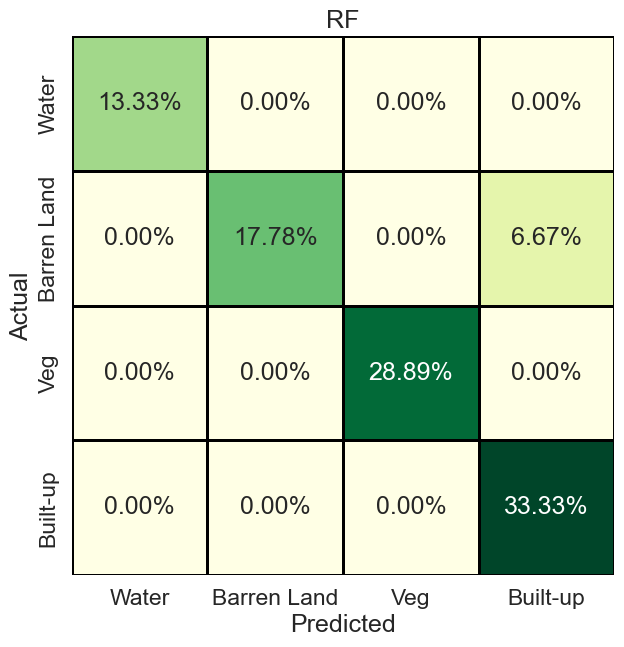

In [15]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

cName = 'RF'


clf_RF = RandomForestClassifier(random_state=42)
clf_RF.fit(X_train, y_train)

clf_pred = clf_RF.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

# Save RF Model

In [16]:
filename = 'Model/finalized_model_RF.sav'
pickle.dump(clf_RF, open(filename, 'wb'))
 
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print('RF Model Score', result)

0.9333333333333333


## full data reshaping, predicting, and saving output

In [17]:
def image_mapper_RF(raster_loc, raster_file_name):

    cName = 'RF'
    exp_name = f'materials/results/lulc_{cName}_{raster_file_name}.tif'


    img = rio.open(raster_loc)
    img_arr = img.read()
    bands = img_arr.shape[0]
    print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
    img_n = np.moveaxis(img_arr, 0, -1) # change shape: (4, 406, 763) ===> (406, 763, 4)
    img_n = img_n.reshape(-1, f_len) # change shape: (406, 763, 4) ===> (406*763, 4)
    print('reshaped full data shape  for prediction: ',img_n.shape)


    pred_full = loaded_model.predict(img_n)

    print('Prediction Done, now exporting raster \n')
    # Predefining out raster meta using variable raster
    tempfile_arr = img.read(1)
    tempfile_arr = tempfile_arr.reshape(-1,1)
    metadata = img.meta

    height = metadata.get('height')
    width = metadata.get('width')
    crs = metadata.get('crs')
    transform = metadata.get('transform')

    img_reshape = pred_full.reshape(height, width)

    out_raster = rio.open(exp_name,
                                            'w',
                                            driver='GTiff',
                                            height=height,
                                            width=width,
                                            count=1,
                                            dtype='uint8',
                                            crs=crs,
                                            transform = transform,
                                            nodata = 255 #nodata
                                            )

    out_raster.write(img_reshape, 1)
    out_raster.close()

    print(f'Raster Map of {raster_file_name} generated by {cName} algorithm was saved!')
    print(100*'#','\n\n')

In [18]:
for i, path_file in enumerate(raster_loc_list):
    image_mapper_RF(path_file, file_names_list[i])

Height: 960
Width: 1621
Bands: 4

reshaped full data shape  for prediction:  (1556160, 4)
Prediction Done, now exporting raster 

Raster Map of area1 generated by RF algorithm was saved!
#################################################################################################### 


Height: 209
Width: 451
Bands: 4

reshaped full data shape  for prediction:  (94259, 4)
Prediction Done, now exporting raster 

Raster Map of area2 generated by RF algorithm was saved!
#################################################################################################### 


Height: 357
Width: 578
Bands: 4

reshaped full data shape  for prediction:  (206346, 4)
Prediction Done, now exporting raster 

Raster Map of area3 generated by RF algorithm was saved!
#################################################################################################### 


